In [1]:
import laspy
import numpy as np
import geopandas as gpd
# Set the grid cells for analysis
import shapely
import numpy as np

In [2]:
las = laspy.read("../data/teak_data/lidarAOI_g.las")

In [3]:
class lasds:
    def __init__(self, lasData, name=None):
        self.x = np.array(lasData.x)
        self.y = np.array(lasData.y)
        self.z = np.array(lasData.z)
        self.classification = np.array(lasData.classification)
        self.scan_angle = las.scan_angle_rank
        self.name = name
        
    def gap_grid(self, grid_res=None, epsg=None):
    
        # get las data into a dataframe
        try:
            d={'x': self.x,'y': self.y, "class":self.classification,"scan_angle":np.absolute(self.scan_angle)}
            las_gdf = gpd.GeoDataFrame(d, geometry=gpd.points_from_xy(self.x, self.y),crs=f"EPSG:{epsg}")
        except:
            print("Need an epsg value..")
            return
        
        # Create a grid of data
        # total area for the grid
        xmin, ymin, xmax, ymax= [min(self.x), min(self.y), max(self.x), max(self.y)]
        # how many cells across and down
        cell_size = grid_res
        # create the cells in a loop
        grid_cells = []
        for x0 in np.arange(xmin, xmax+cell_size, cell_size):
            for y0 in np.arange(ymin, ymax+cell_size, cell_size):
                # bounds
                x1 = x0-cell_size
                y1 = y0+cell_size
                grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
        # Create a gdf with the list of shapely objects
        # CRS for gdf of cells
        crs = f"EPSG:{epsg}"
        cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

        # Reset index for easier analysis nad merge to lvis gdf
        cell.reset_index(inplace=True)
        cell.rename(columns={"index":'cellIdx'},inplace=True)
        merged = gpd.sjoin(cell,las_gdf.reset_index(drop=True),how='left',predicate='intersects')
        
        # Init new fields for gap and LAI to the cell gdf (which will hold our calculated values)
        cell['gap'] = np.nan * len(cell)
        cell['lai'] = np.nan * len(cell)
        
        # Loop through each cellIdx
        for i, group in merged.groupby("cellIdx"):
            
            # if lenght of group is zero, continue to next grid cell
            if np.isnan(group["x"].values).all():
                continue
            # First, lets get the gap probability
            gap = len(group.loc[group['class']==2]) / len(group) 
            
            # Get the average angle in radians
            avg_angle = np.nanmean(group['scan_angle'].values)
            angle_rad = avg_angle * (np.pi/180)
            
            # Calculate total LAI
            G = 0.5 # leaf orientation function
            lai = (-1 * (np.cos(angle_rad)/G) * np.log(gap))
            
            # set values in the cell gdf (automaticalls inits a new columns of nans if columns does not exist)
            cell.at[i, 'gap'] = gap
            cell.at[i, 'lai'] = lai
            
        # return the cell gdf that has the calculate gap and lai for each cell
        return cell

In [4]:
las_ds = lasds(las)

In [5]:
gridded_gap = las_ds.gap_grid(grid_res = 30, epsg=32611)

In [6]:
gridded_gap['gap'].values

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 1.        ,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.62318841, 0.59504685, 0.2217047 ,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.3       ,
       0.23146944, 0.34072581, 0.52402004, 0.724     ,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.34831461, 0.5194493 ,
       0.44795208, 0.49139118, 0.63476071, 0.65923863,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.94849785, 0.61845192, 0.5250699 ,
       0.50912548, 0.47159864, 0.5275101 , 0.49606299,        

In [63]:
def tauR(gap_grid, tree_crowns_fn):
    # tauR for sperical crowns only, =3G(theta)*Lt/(4*lamda*pi*r^2) (set G(theta) = 0.5)from Eqn (3) 
    
    # read in tree crowns
    tree_crowns = gpd.read_file(tree_crowns_fn)
    # Get b/R ratio
    tree_crowns['b_r'] = tree_crowns['vrad']/tree_crowns['hrad']
    
    if tree_crowns.crs != gap_grid.crs:
        # Both left and right gdf must be in the same crs
        print("left and right gdf must be in the same crs...")
        return
    
    # Merge gdf 
    merged = gpd.sjoin(gap_grid,tree_crowns,how='left',predicate='intersects')
    
    # Loop through each cell index and calculate tree density and LAI, and finally tauR 
    for i, group in merged.groupby(merged.index):

        # if lenght of group is zero, continue to next grid cell
        if np.isnan(group["hrad"].values).all():
            continue
        
        # Calculate tauR
        lai = group['lai'].iloc[0]
        gap = group['gap'].iloc[0]
        cell_area = group['geometry'].iloc[0].area
        crown_ct_density = len(group) / cell_area
        R = group['hrad'].mean()
        vrad_avg = group['vrad'].mean()
        szn = group['szn_avg'].mean()
        
        tauR_val = (3 * 0.5 * lai) / (4 * crown_ct_density * np.pi * R**2)
        
        # set values in the cell gdf (automaticalls inits a new columns of nans if columns does not exist)
        gap_grid.at[i, 'tauR'] = tauR_val
        gap_grid.at[i, 'R'] = R
        gap_grid.at[i, 'b'] = vrad_avg
        gap_grid.at[i, 'szn'] = szn
        gap_grid.at[i, 'br'] = vrad_avg / R
        gap_grid.at[i, 'lambda'] = crown_ct_density
        
    return gap_grid

In [65]:
gap_grid_taur = tauR(gridded_gap, "../data/output/teak_crowns_silva/crowns.shp")
    

In [54]:
gap_grid_taur

,cellIdx,geometry,gap,lai,tauR,R,b,szn,br
0,0,"POLYGON ((320613.510 4096591.350, 320613.510 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"POLYGON ((320613.510 4096621.350, 320613.510 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"POLYGON ((320613.510 4096651.350, 320613.510 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,"POLYGON ((320613.510 4096681.350, 320613.510 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,"POLYGON ((320613.510 4096711.350, 320613.510 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
190,190,"POLYGON ((320973.510 4096891.350, 320973.510 4...",0.530021,1.260546,0.616385,3.234487,8.315476,6.966683,2.570879
191,191,"POLYGON ((320973.510 4096921.350, 320973.510 4...",0.605522,0.986991,0.518324,3.371179,8.896944,8.949330,2.639120
192,192,"POLYGON ((320973.510 4096951.350, 320973.510 4...",0.641784,0.869775,0.505826,2.834006,7.951739,10.170288,2.805830
193,193,"POLYGON ((320973.510 4096981.350, 320973.510 4...",0.689774,0.735587,1.095519,2.269891,7.304286,7.123025,3.217901


In [48]:
def clumpingindex(tauR, theta, br):
    # tauR for sperical crowns only, =3G(theta)*Lt/(4*lamda*pi*r^2) (set G(theta) = 0.5)from Eqn (3) in my document
    # theta - solar zenith angle 
    # br - ratio of vertical crown radius/horizontal crown radius

    # Relationship between tauR vs q and tauR vs approaximated q (eqns (20) and (21) in Li-Strahler, 1988 paper) 
    # (1) for sperical crowns,  q values  (eqns (20) and (21) in Li-Strahler, 1988 paper)
    q = (1- (2*tauR+1)*np.exp(-2*tauR))/(2*tauR**2)
    # q_app = 1 - (4/3)*tauR + np.power(tauR, 2) - (8/15)*np.power(tauR, 3)
    q_app = 1 - (4/3)*tauR + np.power(tauR, 2)
    # clumping 
    omega = 3*(1-q)/(4*tauR) 
    omega_app = 3*(1-q_app)/(4*tauR) 

    # (2) for elliposidal crowns
    gamma = np.sqrt( (1+(br*np.tan(theta))**2)/((1+(np.tan(theta))**2)) )

    # sperical tauR to ellipsoidal  (Eqn (7) in Ni-Meister et al, 2010,  Eqn (25) in Li-Strahler, 1998
    tauR_ellip = tauR/gamma 
    tauR = tauR_ellip 
    q = (1- (2*tauR+1)*np.exp(-2*tauR))/(2*tauR**2)
    #q_app = 1 - (4/3)*tauR + np.power(tauR, 2) - (8/15)*np.power(tauR, 3)
    q_app = 1 - (4/3)*tauR + np.power(tauR, 2)
    omega = 3*(1-q)/(4*tauR) 
    omega_app = 3*(1-q_app)/(4*tauR) 
    
    return omega

In [58]:
# Go through each row and calc clumping index
for i, row in gap_grid_taur.iterrows():

    if np.isnan(row['lai']):
        continue
    
    omega = clumpingindex(row['tauR'], row['szn'], row['br'])
    
    # set values in the cell gdf (automaticalls inits a new columns of nans if columns does not exist)
    gap_grid_taur.at[i, 'ci'] = omega

In [67]:
# Save data to shapefile
gap_grid_taur.to_file("../data/output/gridded_ci")

In [66]:
gap_grid_taur

,cellIdx,geometry,gap,lai,tauR,R,b,szn,br,ci,lambda
0,0,"POLYGON ((320613.510 4096591.350, 320613.510 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"POLYGON ((320613.510 4096621.350, 320613.510 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"POLYGON ((320613.510 4096651.350, 320613.510 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,"POLYGON ((320613.510 4096681.350, 320613.510 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,"POLYGON ((320613.510 4096711.350, 320613.510 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
190,190,"POLYGON ((320973.510 4096891.350, 320973.510 4...",0.530021,1.260546,0.616385,3.234487,8.315476,6.966683,2.570879,0.784017,0.023333
191,191,"POLYGON ((320973.510 4096921.350, 320973.510 4...",0.605522,0.986991,0.518324,3.371179,8.896944,8.949330,2.639120,0.782454,0.020000
192,192,"POLYGON ((320973.510 4096951.350, 320973.510 4...",0.641784,0.869775,0.505826,2.834006,7.951739,10.170288,2.805830,0.836303,0.025556
193,193,"POLYGON ((320973.510 4096981.350, 320973.510 4...",0.689774,0.735587,1.095519,2.269891,7.304286,7.123025,3.217901,0.734909,0.015556


In [2]:
## View the tree crowns vertical and horizontal radii distribution

In [7]:
teak_crowns = gpd.read_file("../data/output/teak_crowns_silva/crowns.shp")

In [34]:
teak_crowns

,treeID,XTOP,YTOP,ZTOP,szn_avg,area,hrad,vrad,geometry
0,480,320998.04,4096919.98,23.47,8.005882,38.2704,3.490250,11.735,POINT (320997.600 4096919.636)
1,407,320997.83,4096933.81,22.65,11.312500,31.7568,3.179387,11.325,POINT (320998.354 4096934.539)
2,397,320991.94,4096934.98,11.91,12.943878,26.4810,2.903302,5.955,POINT (320991.779 4096934.064)
3,358,320982.90,4096941.78,25.54,9.262987,65.1744,4.554740,12.770,POINT (320982.730 4096941.465)
4,308,320981.79,4096946.46,14.55,14.521978,25.2735,2.836337,7.275,POINT (320982.908 4096949.032)
...,...,...,...,...,...,...,...,...,...
1482,190,320657.99,4096969.44,13.63,7.933333,4.1256,1.145958,6.815,POINT (320658.761 4096969.357)
1483,191,320678.57,4096968.53,10.12,8.214286,34.6709,3.322061,5.060,POINT (320679.958 4096967.912)
1484,2,320679.03,4096999.87,10.87,8.000000,7.5440,1.549622,5.435,POINT (320676.855 4096999.053)
1485,15,320711.25,4096999.22,14.45,9.000000,0.5616,0.422804,7.225,POINT (320711.223 4096998.366)


In [5]:
teak_crowns['b_r'] = teak_crowns['vrad']/teak_crowns['hrad']

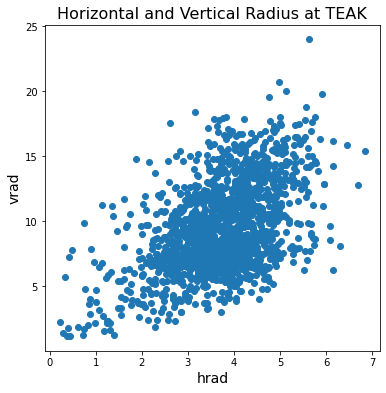

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(teak_crowns['hrad'],teak_crowns['vrad'])
plt.xlabel("hrad",fontsize=14)
plt.ylabel("vrad",fontsize=14)
plt.title("Horizontal and Vertical Radius at TEAK", fontsize=16)
plt.savefig("../figs/silva_vradhrad_scatter_teak.png")

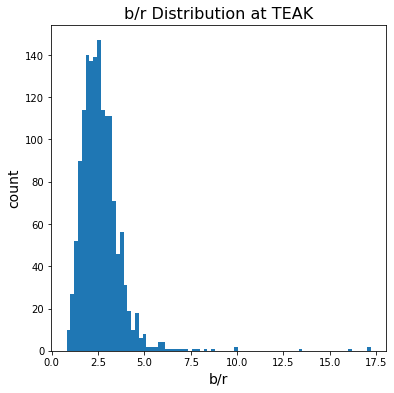

In [12]:
plt.figure(figsize=(6,6))
plt.hist(teak_crowns['b_r'],bins="auto")
plt.xlabel("b/r",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.title("b/r Distribution at TEAK", fontsize=16)
plt.savefig("../figs/silva_br_hist_teak.png")

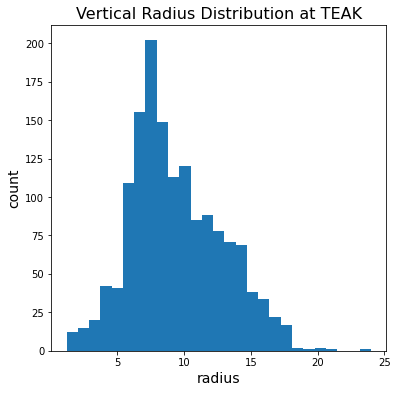

In [13]:
plt.figure(figsize=(6,6))
plt.hist(teak_crowns['vrad'],bins="auto")
plt.xlabel("radius",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.title("Vertical Radius Distribution at TEAK", fontsize=16)
plt.savefig("../figs/silva_vrad_hist_teak.png")

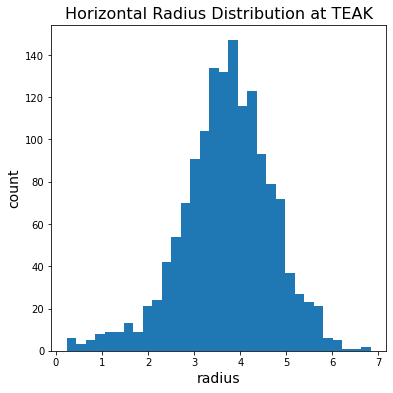

In [14]:
plt.figure(figsize=(6,6))
plt.hist(teak_crowns['hrad'],bins="auto")
plt.xlabel("radius",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.title("Horizontal Radius Distribution at TEAK", fontsize=16)
plt.savefig("../figs/silva_hrad_hist_teak.png")

In [15]:
teak_crowns.loc[teak_crowns['b_r']>8] # .to_file("teakcrowns_br_gt8.shp")

,treeID,XTOP,YTOP,ZTOP,szn_avg,area,hrad,vrad,geometry,b_r
564,64,320717.36,4096994.30,19.79,14.000000,1.7172,0.739325,9.895,"POLYGON ((320716.860 4096993.740, 320717.030 4...",13.383826
836,149,320986.79,4096981.35,15.62,8.000000,0.7469,0.487592,7.810,"POLYGON ((320986.700 4096981.230, 320986.260 4...",16.017500
1407,7,320866.85,4096999.78,11.41,7.800000,0.3450,0.331386,5.705,"POLYGON ((320867.290 4096999.290, 320867.060 4...",17.215555
1408,1493,320999.99,4096605.11,4.52,5.500000,0.1650,0.229175,2.260,"POLYGON ((320999.920 4096604.560, 320999.690 4...",9.861464
1413,656,320704.68,4096886.79,22.33,8.000000,5.7135,1.348578,11.165,"POLYGON ((320706.970 4096887.040, 320705.900 4...",8.279089
1446,569,320770.64,4096902.67,15.82,9.055556,2.5388,0.898958,7.910,"POLYGON ((320770.990 4096901.070, 320770.640 4...",8.799078
1481,156,320655.09,4096975.88,22.48,7.625000,3.9996,1.128323,11.240,"POLYGON ((320655.460 4096975.780, 320655.220 4...",9.961689
1485,15,320711.25,4096999.22,14.45,9.000000,0.5616,0.422804,7.225,"POLYGON ((320711.270 4096997.660, 320711.030 4...",17.088315


In [36]:
############
## SCRATCH
############

In [136]:
from scipy import stats
binx=np.arange(min(las.x),max(las.x),30)
biny=np.arange(min(las.y),max(las.y),30)

ret = stats.binned_statistic_2d(np.array(las.x), np.array(las.y), np.array(las.z), 'count',
                                bins=[binx, biny])

In [137]:
np.nansum(ret.statistic)

351776.0

In [123]:
len(las.x)

424122

In [140]:
ret.x_edge

array([320643.51, 320673.51, 320703.51, 320733.51, 320763.51, 320793.51,
       320823.51, 320853.51, 320883.51, 320913.51, 320943.51, 320973.51])

In [ ]:
bbox = [(min(las.x), min(las.y)), (max(las.x), max(las.y))]

In [9]:
import shapely
import geopandas as gpd
# total area for the grid
xmin, ymin, xmax, ymax= [min(las.x), min(las.y), max(las.x), max(las.y)]
# how many cells across and down
# n_cells=51 # 30.5 meters
cell_size = 30
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
# Create a gdf with the list of shapely objects
# CRS for gdf of cells
crs = "EPSG:32611"
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

<AxesSubplot:>

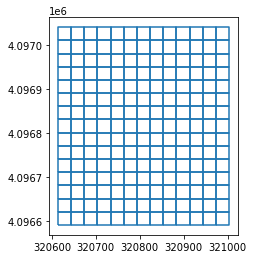

In [10]:
cell.boundary.plot()

In [158]:
poly = cell.iloc[0]['geometry']

In [193]:
# cell.reset_index(inplace=True)
# cell.rename(columns={"index":'cellIdx'},inplace=True)
merged = gpd.sjoin(cell,las_gdf.reset_index(drop=True),how='left',predicate='intersects')

In [282]:
merged.loc[merged['cellIdx']==13]

,cellIdx,geometry,index_right,x,y,class,scanangle
13,13,"POLYGON ((320613.510 4096981.350, 320613.510 4...",413767.0,320643.51,4096999.88,2.0,8.0


In [ ]:
for idx, group in merged.groupby("index"):
    print(idx)

In [194]:
merged.columns

Index(['cellIdx', 'geometry', 'index_right', 'x', 'y', 'class', 'scanangle'], dtype='object')

In [199]:
merged_26 = merged.loc[merged['cellIdx']==26]

In [203]:
np.nanmean(merged_26['scanangle'].values)

7.7898550724637685

In [209]:
len(merged_26.loc[merged_26['class']==2]) / len(merged_26) 

0.6231884057971014

In [ ]:
# Join the grid and points
merged = gpd.sjoin(cell,lvis_agb_gdf, how='left',op='intersects')

In [ ]:
merged.reset_index(inplace=True)
merged.rename(columns={"index":"cellIdx"},inplace=True)

In [ ]:
dfList = []
for idx, group in merged.groupby(by="cellIdx"):
    
    agbd = group['biWF'].mean() * 0.7
    agbd_std = group['biWF'].std()

    # add values to cell df
    df = pd.DataFrame(data={"cellIdx":[idx],
                            "agbd":[agbd],
                            "agbd_std": [agbd_std],
                           "geometry":[group['geometry'].iloc[0]]})
    dfList.append(df)

# Combine dataframes together rowise
merged_stats_gdf = pd.concat(dfList)

In [53]:
np.array(las.z[:100])

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  8.83,  8.86,
        9.29,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  5.36, 16.22,  0.21,  0.  ,  0.  ,
        0.  ,  9.89,  4.94,  9.14,  0.  ,  0.  ,  8.53,  4.82,  0.05,
        0.  ,  8.24,  0.  ,  0.  , 10.74,  0.  ,  0.  ,  0.  ,  9.61,
        0.  ,  0.  ,  0.  , 14.81,  0.  ,  0.  ,  0.  ,  0.  ,  5.08,
        0.  , 13.13,  0.  ,  0.  ,  7.39,  0.  ,  5.48,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        3.  ,  0.  ,  3.51,  3.28,  0.  ,  0.  ,  0.  ,  0.  , 18.37,
        0.  ,  0.  , 16.26,  0.08,  0.  ,  0.  ,  0.25,  8.08,  0.  ,
        0.  ,  9.44,  0.  ,  0.26,  6.45,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ])

In [19]:
binx=np.arange(min(las.x),max(las.x),30)
biny=np.arange(min(las.y),max(las.y),30)

xx, yy = np.meshgrid(binx,biny)

In [18]:
xx.shape

(14, 12)

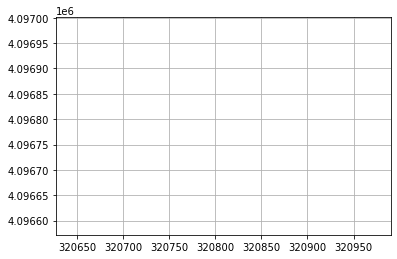

In [29]:
import matplotlib.pyplot as plt
plt.plot(xx,yy, marker="",ls="")
plt.grid(True)

In [ ]:
def mean_height(x,y,zvals):
    # get the indices for values taht fill in the xy grid
    idxs =np.nonzero()

In [44]:
a = np.array([[1,3,6,8,1,9,7,2,3],
            [6,5,6,8,1,9,7,2,3]])

np.nonzero(a < 5)

(array([0, 0, 0, 0, 0, 1, 1, 1]), array([0, 1, 4, 7, 8, 4, 7, 8]))

In [39]:
las_vstack

array([[3.20999120e+05, 4.09692247e+06, 0.00000000e+00, 2.00000000e+00,
        1.90000000e+01],
       [3.20997330e+05, 4.09692541e+06, 0.00000000e+00, 2.00000000e+00,
        1.90000000e+01],
       [3.20995030e+05, 4.09692695e+06, 0.00000000e+00, 2.00000000e+00,
        1.90000000e+01],
       ...,
       [3.20847550e+05, 4.09680961e+06, 2.42700000e+01, 1.00000000e+00,
        3.00000000e+00],
       [3.20847390e+05, 4.09681027e+06, 2.29400000e+01, 1.00000000e+00,
        3.00000000e+00],
       [3.20978590e+05, 4.09686095e+06, 2.22600000e+01, 1.00000000e+00,
        5.00000000e+00]])

In [24]:
list(las.point_format.dimension_names)

['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'synthetic',
 'key_point',
 'withheld',
 'scan_angle_rank',
 'user_data',
 'point_source_id',
 'gps_time',
 'red',
 'green',
 'blue']

In [25]:
las.scan_angle_rank

array([19, 19, 19, ..., -3, -3, -5], dtype=int8)

In [22]:
dir(las.point_format.dimension_names)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_extra_dimension',
 'dimension_by_name',
 'dimension_names',
 'dimensions',
 'dtype',
 'extra_dimension_names',
 'extra_dimensions',
 'has_waveform_packet',
 'id',
 'num_extra_bytes',
 'num_standard_bytes',
 'size',
 'standard_dimension_names',
 'standard_dimensions']